In [1]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf
abs_config_dir = os.path.abspath("config/")

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="test_hartmann.yaml", overrides=[])
    print(OmegaConf.to_yaml(config))
    print(config)

config.sampler.conf.logger.do.online = False

dataset:
  grid_size: 10
  normalize_scores: true
  train_fraction: 1.0
  batch_size: 16384
  shuffle: true
  train_path: ~/activelearning/my_package/storage/branin/data_100_train.csv
  test_path: null
  _target_: dataset.grid.HartmannDatasetHandler
oracle:
  _target_: oracle.oracle.Hartmann
  fidelity: 1
  do_domain_map: true
filter:
  _target_: filter.filter.ScoreFilter
sampler:
  conf:
    state_flow: null
    policy:
      forward:
        _target_: gflownet.policy.base.Policy
        config:
          type: mlp
          n_hid: 2048
          n_layers: 2
          checkpoint: null
          reload_ckpt: false
          is_model: false
      backward:
        _target_: gflownet.policy.base.Policy
        config: null
      shared: null
    env:
      _target_: gflownet.envs.grid.Grid
      id: grid
      func: corners
      n_dim: 6
      length: 10
      max_increment: 1
      max_dim_per_action: 1
      cell_min: 0
      cell_max: 0.99
      buffer:
        train: null
        te

/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'test_hartmann.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [2]:
import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = config.device
n_iterations = config.budget  # TODO: replace with budget
grid_size = config.dataset.grid_size
n_samples = config.n_samples
maximize = config.maximize

from gflownet.utils.common import set_float_precision
float_prec = set_float_precision(config.float_precision)

import matplotlib.colors as cm
import matplotlib.pyplot as plt
# colors = ["red", "blue", "green", "orange", "brown", "pink"]
colors = plt.get_cmap("Reds")

In [3]:
from dataset.grid import HartmannDatasetHandler
from utils.logger import WandBLogger
from utils.plotter import ProjectionPlotHelper


# Dataset
dataset_handler = HartmannDatasetHandler(
    grid_size=grid_size,
    train_path="./storage/hartmann/data_train.csv",
    train_fraction=1.0,
    float_precision=float_prec,
)
candidate_set, xi, yi = dataset_handler.get_candidate_set(step=1, as_dataloader=True)
plot_set, _, _ = dataset_handler.get_candidate_set(step=2, as_dataloader=False)

logger = WandBLogger(project_name="test_hartmann_plots", run_name="GFN identity lr5e-4 acqfilter")
# plotter = None
plotter = ProjectionPlotHelper(plot_set[:], logger)
# plotter.logger = logger

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: christina-humer. Use `wandb login --relogin` to force relogin


/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)



            Important: offline trajectories will NOT be sampled. In order to sample
            offline trajectories, the train configuration of the buffer should be
            complete and feasible and an output pkl file should be defined in
            env.buffer.train.output_pkl.
            

            Important: test metrics will NOT be computed. In order to compute
            test metrics the test configuration of the buffer should be complete and
            feasible and an output pkl file should be defined in
            env.buffer.test.output_pkl.
            


  0%|          | 0/100 [00:00<?, ?it/s]/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/gflownet/utils/buffer.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.main = pd.concat(
Loss: 855.9722 | Mean rewards: 0.07 | JSD: -1.0000: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]
/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yva


            Important: offline trajectories will NOT be sampled. In order to sample
            offline trajectories, the train configuration of the buffer should be
            complete and feasible and an output pkl file should be defined in
            env.buffer.train.output_pkl.
            

            Important: test metrics will NOT be computed. In order to compute
            test metrics the test configuration of the buffer should be complete and
            feasible and an output pkl file should be defined in
            env.buffer.test.output_pkl.
            


  0%|          | 0/100 [00:00<?, ?it/s]/home/mila/c/christina.humer/.conda/envs/al_new/lib/python3.10/site-packages/gflownet/utils/buffer.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.main = pd.concat(
Loss: 1015.0827 | Mean rewards: 0.09 | JSD: -1.0000:   7%|▋         | 7/100 [00:03<00:44,  2.07it/s]


KeyboardInterrupt: 

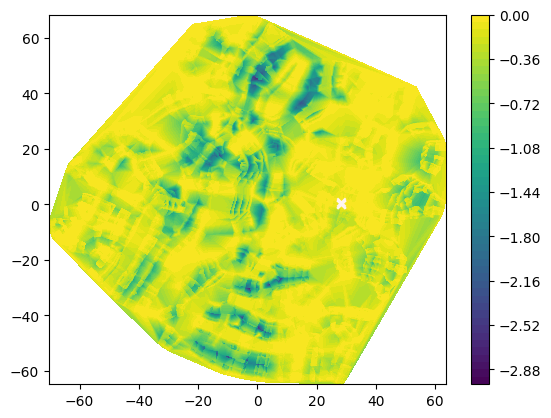

In [4]:
from surrogate.surrogate import SingleTaskGPRegressor
from sampler.sampler import GreedySampler, RandomSampler
from filter.filter import Filter, ScoreFilter
from oracle.oracle import HartmannOracle

# Oracle
oracle = HartmannOracle(fidelity=1, device=device, float_precision=float_prec)

if plotter is not None:
    fig_oracle, ax_oracle = plotter.plot_function(oracle)


best_scores = []

for i in range(n_iterations):

    train_data, test_data = dataset_handler.get_dataloader()
    # print("iteration", i)
    # Surrogate (e.g., Bayesian Optimization)
    # starts with a clean slate each iteration
    surrogate = SingleTaskGPRegressor(
        float_precision=float_prec, device=device, maximize=maximize
    )
    surrogate.fit(train_data)

    # Sampler (e.g., GFlowNet, or Random Sampler)
    # also starts with a clean slate; TODO: experiment with NOT training from scratch
    # sampler = RandomSampler(
    #     surrogate,
    # )
    # sampler = GreedySampler(
    #     surrogate,
    #     device=device,
    #     float_precision=float_prec,
    # )
    sampler = hydra.utils.instantiate(
        config.sampler,
        surrogate=surrogate,
        device=device,
        float_precision=float_prec,
        _recursive_=False,
    )

    sampler.fit()  # only necessary for samplers that train a model

    samples = sampler.get_samples(n_samples * 5, candidate_set=candidate_set)
    
    if plotter is not None and hasattr(sampler, "sampler"):
        def reward_fn(samples):
            return sampler.sampler.env.proxy2reward(sampler.sampler.env.proxy(samples))
        fig_reward, ax_reward = plotter.plot_function(reward_fn)
        fig_reward, ax_reward = plotter.plot_samples(samples, ax_reward, fig_reward)
        ax_reward.set_title("reward fn + proposed samples of iteration %i"%i)
        plotter.log_figure(fig_reward, "reward")


    # Filter
    # filter = Filter()
    filter = ScoreFilter(surrogate.get_acquisition_values)
    filtered_samples = filter(n_samples=n_samples, candidate_set=samples.clone())

    if plotter is not None:
        fig_acq, ax_acq = plotter.plot_function(surrogate)
        fig_acq, ax_acq = plotter.plot_samples(filtered_samples, ax_acq, fig_acq)
        ax_acq.set_title("acquisition fn + selected samples of iteration %i" % i)
        plotter.log_figure(fig_acq, "acq")

    if plotter is not None:
        fig_acq, ax_acq = plotter.plot_samples(
            filtered_samples,
            ax_oracle,
            fig_oracle,
            c=cm.to_hex(colors(i / n_iterations)),
            label="it %i" % i,
        )

    del surrogate
    del sampler
    del filter

    scores = oracle(filtered_samples.clone())
    dataset_handler.update_dataset(filtered_samples.cpu(), scores.cpu())
    best_scores.append(scores.min().cpu())
    if logger is not None:
        logger.log_metric(scores.min().cpu(), "best_score")

if plotter is not None:
    fig_oracle.legend()
    ax_oracle.set_title("oracle fn + samples")
    plotter.log_figure(fig_oracle, key="oracle")


fig = plt.figure()
plt.plot(best_scores)
plt.xlabel("iterations")
plt.ylabel("scores")
plt.title("Best Score in each iteration")
if plotter is not None:
    plotter.log_figure(fig, key="best_scores")

In [ ]:
from importlib import reload
import surrogate.surrogate as sgt
reload(sgt)

<module 'surrogate.surrogate' from '/home/mila/c/christina.humer/activelearning/my_package/surrogate/surrogate.py'>

In [ ]:
sampler.sampler.env.

AttributeError: 'Grid' object has no attribute 'grid_size'